# Adding concentrated and distributed moving loads to a beam.

In this example
- we define a simply supported beam
- we assign a material and a cross section to the beam
- we define concentrated and distributed moving loads
- we run a linear analysis
- we make a screenshot

## Launch AxisVM

We launch an instance of AxisVM.

In [1]:
from axisvm.com.client import start_AxisVM

axisvm_application = start_AxisVM(visible=True, daemon=True)

We import the type library. This is done on a separate line to ensure that the notebook runs correctly for first timers too, since in that case the type library is dynamicall generated with the first launch of an AxisVM instance, which could be the previus block. If this is not the first time you use the library, you can do all the import statements right below each other.

In [2]:
import axisvm.com.tlb as axtlb

## Create a new model

In [3]:
axisvm_model_id = axisvm_application.Models.New()
axisvm_model = axisvm_application.Models.Item[axisvm_model_id]

## Define a material and a cross section

Since it is not the goal of this example to show how to define materials and cross sections, we opt for a simple steel I section combination.

In [4]:
# setting the national design code
axisvm_model.Settings.NationalDesignCode = axtlb.ndcEuroCode

# setting the material
material_id = axisvm_model.Materials.AddFromCatalog(axtlb.ndcEuroCode, "S 235")
assert material_id > 0, f"An error occured. Error code: {material_id}"

# setting the cross section
section_id = axisvm_model.CrossSections.AddFromCatalog(axtlb.cssI, "I 200")
assert section_id > 0, f"An error occured. Error code: {section_id}"

## Create the geometry

Define the nodes


In [5]:
node_id_1 = axisvm_model.Nodes.AddWithDOF(0, 0, 0, axtlb.dofFrameXZ)
assert node_id_1 > 0, f"An error occured. Error code: {node_id_1}"

node_id_2 = axisvm_model.Nodes.AddWithDOF(4, 0, 0, axtlb.dofFrameXZ)
assert node_id_2 > 0, f"An error occured. Error code: {node_id_2}"

Define the line of the beam


In [6]:
line_id = axisvm_model.Lines.Add(node_id_1, node_id_2, axtlb.lgtStraightLine)[-1]
assert line_id > 0, f"An error occured. Error code: {line_id}"

## Create the structural member

In [7]:
# add the member
member_id = axisvm_model.Members.Add([line_id])
assert member_id > 0, f"An error occured. Error code: {member_id}"

# access the newly created member
member = axisvm_model.Members.Item[member_id]

# define the beam
beam_id = member.DefineAsBeam(material_id, section_id, section_id)[-1]

## Define the supports

We define the support conditions of a simply-supported beam.

In [8]:
# spring stiffness values
springleft = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=0, yy=0, zz=0)
springright = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=0, yy=0, zz=0)

# spring behaviour
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression,
)

# spring resistances
RResistances = axtlb.RResistances(x=0, y=0, z=0, xx=0, yy=0, zz=0)

# add the left support
return_value = axisvm_model.NodalSupports.AddNodalGlobal(
    springleft, RNonLinearity, RResistances, node_id_1
)[-1]
assert return_value > 0, f"An error occured. Error code: {return_value}"

# add the right support
return_value = axisvm_model.NodalSupports.AddNodalGlobal(
    springright, RNonLinearity, RResistances, node_id_2
)[-1]
assert return_value > 0, f"An error occured. Error code: {return_value}"

## Define loads

### Permanent load group

We crate a load group for permanent loads first and add the self-weight of the beam to a load case.

In [9]:
# create a new load gruop
group_id = axisvm_model.LoadGroups.Add(
    "Permanent", axtlb.lgtPermanent, True, axtlb.gctAdditive
)
assert group_id > 0, f"An error occured. Error code: {group_id}"

# create a load case for the self-weight
load_case_id = axisvm_model.LoadCases.AddWithGroup("G", axtlb.lctStandard, group_id)
assert load_case_id > 0, f"An error occured. Error code: {load_case_id}"

# add the self-weight to the load case
return_value = axisvm_model.Loads.AddBeamSelfWeight(line_id, load_case_id)
assert return_value > 0, f"An error occured. Error code: {return_value}"

### Adding a concentrated moving load

First and foremost we create a dedicated load group for our moving load with a load case in it. We add the initial load case with the name "XXX-001", where "XXX" is the fantasy name of the load ('MC' in this case). The reason for the part "-001" is that when AxisVM generated the discrete positions of the moving load, it is going to use this naming convention anyway.

In [10]:
# create a dedicated load group
group_id = axisvm_model.LoadGroups.Add(
    "moving-conc", axtlb.lgtMoving, False, axtlb.gctExclusive
)

# create a load case
load_case_id = axisvm_model.LoadCases.AddWithGroup("MC-001", axtlb.lctMoving, group_id)
assert load_case_id > 0, f"An error occured. Error code: {load_case_id}"

Adding moving loads can be done using the `ObjectCreator` interface. First, we need to create an instance to the `IAxisVMMovingLoadOnBeam` interface. We need to do this for every moving load we want to add to the model.

In [11]:
# create an object that holds onto the data
MovingLoadOnBeam = axisvm_application.ObjectCreator.NewMovingLoadOnBeam()

# define settings of the moving load
MovingLoadOnBeam.LoadCaseId = load_case_id
MovingLoadOnBeam.RunningMode = axtlb.rmOneWay
MovingLoadOnBeam.Steps = 10
MovingLoadOnBeam.StructureMode = axtlb.smBridge
return_value = MovingLoadOnBeam.SetPath([line_id], node_id_1, node_id_2)
assert return_value > 0, f"An error occured. Error code: {return_value}"

Then we can use the `AddItem` function of our newly created interface to add moving loads. For this, we neeed to prepare a `RMovingLoadOnBeamItem` record and feed it to the `AddItem` function.

In [12]:
# set the load values
moving_load_data = axtlb.RMovingLoadOnBeamItem(
    ItemType=axtlb.ltBeamConcentrated,
    Concentrated=axtlb.RConcentratedMovingLoadOnBeam(
        SystemGL=axtlb.sysGlobal,
        Position=0.0,
        Fz=-1.0,
    )
)

# define the load item
moving_load_beam_index = MovingLoadOnBeam.AddItem(moving_load_data)[-1]
assert moving_load_beam_index > 0, f"An error occured. Error code: {moving_load_beam_index}"

Finally, we add the moving load to the model:

In [13]:
# add the moving load to the beam
return_value = axisvm_model.MovingLoads.AddMovingLoadOnBeam(MovingLoadOnBeam)
assert return_value > 0, f"An error occured. Error code: {return_value}"

### Adding a distributed moving load

For defining a distributed moving load, we need to perform the same steps as for the concentrated one, except the definition of the load values. This time, we do all these steps in one block.

In [14]:
# create a dedicated load group
group_id = axisvm_model.LoadGroups.Add(
    "moving-dist", axtlb.lgtMoving, False, axtlb.gctExclusive
)

# create a load case
load_case_id = axisvm_model.LoadCases.AddWithGroup("MD-001", axtlb.lctMoving, group_id)
assert load_case_id > 0, f"An error occured. Error code: {load_case_id}"

# create an object that holds onto the data
MovingLoadOnBeam = axisvm_application.ObjectCreator.NewMovingLoadOnBeam()

# define settings of the moving load
MovingLoadOnBeam.LoadCaseId = load_case_id
MovingLoadOnBeam.RunningMode = axtlb.rmOneWay
MovingLoadOnBeam.Steps = 10
MovingLoadOnBeam.StructureMode = axtlb.smBridge
return_value = MovingLoadOnBeam.SetPath([line_id], node_id_1, node_id_2)
assert return_value > 0, f"An error occured. Error code: {return_value}"

# set the load values
moving_load_data = axtlb.RMovingLoadOnBeamItem(
    ItemType=axtlb.ltBeamDistributed,
    Distributed=axtlb.RDistributedMovingLoadOnBeam(
        SystemGL=axtlb.sysGlobal,
        Position1=0.0,
        Position2=1.0,
        Fz1=-1.0,
        Fz2=-1.0,
    )
)

moving_load_beam_index = MovingLoadOnBeam.AddItem(moving_load_data)[-1]
assert moving_load_beam_index > 0, f"An error occured. Error code: {moving_load_beam_index}"

# add the moving load to the beam
return_value = axisvm_model.MovingLoads.AddMovingLoadOnBeam(MovingLoadOnBeam)
assert return_value > 0, f"An error occured. Error code: {return_value}"

## Save the model

It is necessary to save the model before running an analysis.

In [15]:
file_path = 'model.axs'
return_value = axisvm_model.SaveToFile(file_path, False)
assert return_value > 0, f"An error occured. Error code: {return_value}"

## Linear analysis

We perform a simple linear analysis.

In [16]:
return_value = axisvm_model.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)
assert return_value > 0, f"An error occured. Error code: {return_value}"

## Take a screenshot

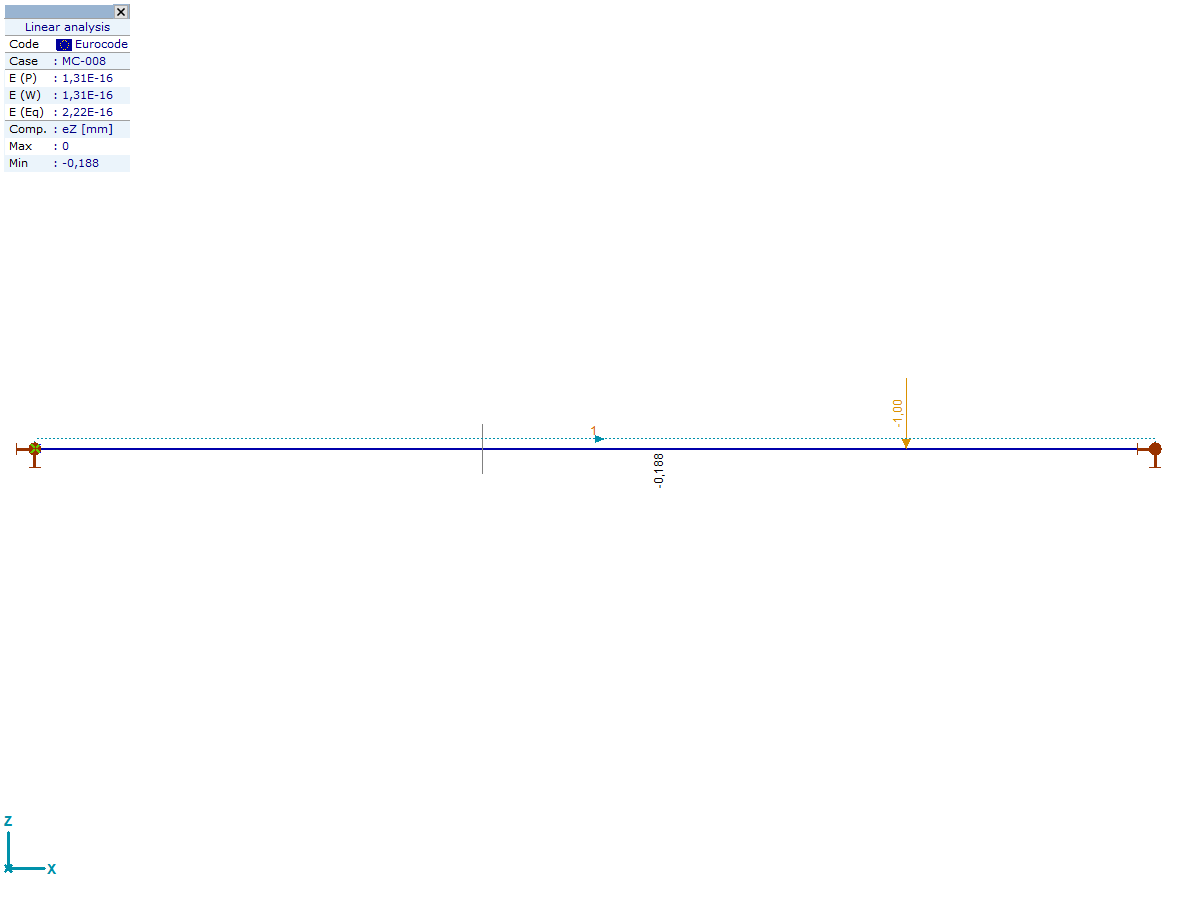

In [17]:
axisvm_model.View = axtlb.vFront
axisvm_model.FitInView()

GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axisvm_model.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmDiagramFilled,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)

load_case_id = 10
axisvm_model.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, load_case_id, [])

axisvm_model.Windows.ReDraw()
axisvm_application.BringToFront()
axisvm_model.Windows[1].screenshot()

## Close the application

At the end of our workflow, we close AxisVM.

In [18]:
axisvm_application.Quit()